In [1]:
import gymnasium as gym
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(12, 6
    
    ),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="small",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=True,
)

/var/folders/d5/fp2qfypj2fq0b5zqrdmh8k2m0000gn/T/ipykernel_4568/1334598270.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


# Cart Pole

https://gymnasium.farama.org/environments/classic_control/cart_pole/

### 1. Random Actions:

**Objective**: Understand the environment and its dynamics.

**Task**:
- Initialize the environment.
- At each step, choose an action randomly.
- Observe the consequences of the action in terms of the next state, reward, and whether the episode has ended.

**Expected Outcome**: 
- The pole will likely fall quickly.
- Gain an intuitive understanding of the environment's dynamics.



In [3]:
env = gym.make('CartPole-v1', render_mode='rgb_array')

In [5]:
num_episodes = 50
episode_scores = {}

for episode in range(num_episodes):
    observation = env.reset() 
    episode_reward = 0 
    while True:
        env.render()

        # actions are 0 or 1 (move left or right)
        action = env.action_space.sample()  

        # observation is a 4-tuple of floats: cart_position, cart_velocity, pole_angle, pole_angular_velocity 
        # info is usually(?) empty for cartpole
        observation, reward, terminated, truncated, info = env.step(action)
        
        episode_reward += reward  
        
        if terminated or truncated:
            episode_scores[f"episode_{episode}"] = episode_reward
            break

env.close()

In [6]:
mean_score = sum(episode_scores.values()) / len(episode_scores)
mean_score

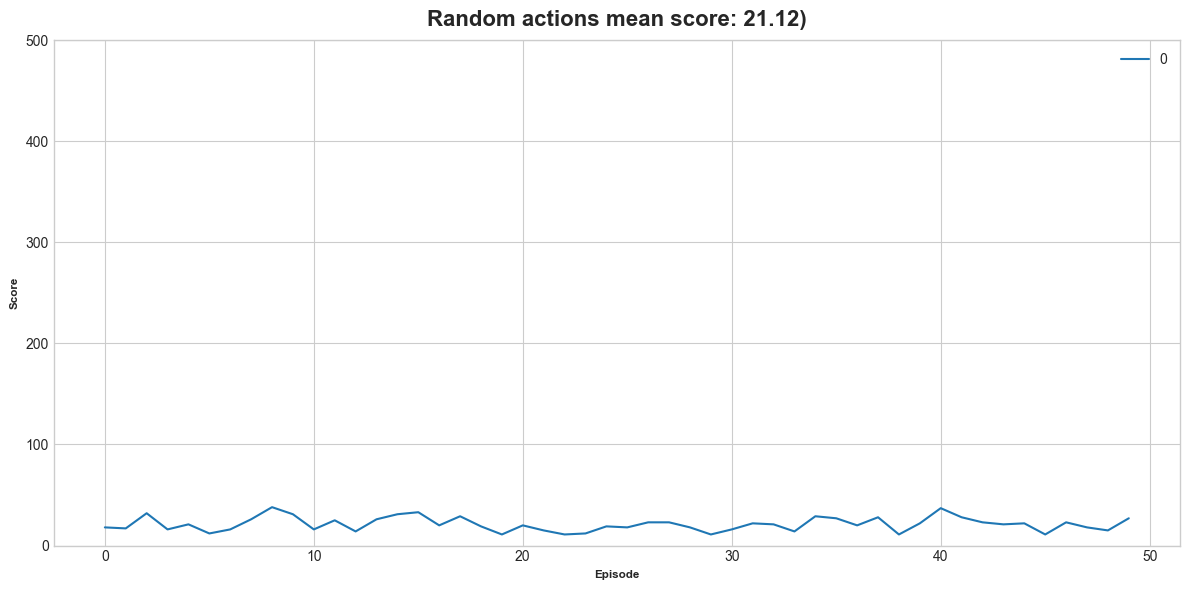

In [7]:
# reward is +1 for every step, so the scores are just the episode lengths
plot_data = pd.DataFrame(episode_scores.values())
sns.lineplot(plot_data)
plt.title(f'Random actions mean score: {mean_score:.2f})')
plt.xlabel('Episode')
plt.ylabel('Score')
plt.ylim(0,500)  # truncation happens at 500 steps
plt.show()

### 2. Tabular Q-learning (if state space is discretized):

**Objective**: Grasp the concept of value-based learning.

**Task**:
- Discretize the state space into bins.
- Create a Q-table with state-action pairs.
- Implement the Q-learning algorithm to update Q-values.
- Choose actions using an epsilon-greedy policy.

**Expected Outcome**:
- Initial unstable results, but with enough episodes and appropriate hyperparameters, you should see improvements in the agent's performance.



In [88]:
def discretize_state(observation, bins):
    
    """Discretize a continuous observation into discrete values."""
    # Define the range for each observation value
    state_bounds = [(-2.4, 2.4), (-3, 3), (-0.21, 0.21), (-3, 3)]  # OK for CartPole-v1?

    discrete_observation = []
    
    for i in range(len(observation)):
        # Clip the observation value within defined bounds
        obs = np.clip(observation[i], state_bounds[i][0], state_bounds[i][1])
        
        # Scale the observation to the range [0, 1]
        scaled_obs = (obs - state_bounds[i][0]) / (state_bounds[i][1] - state_bounds[i][0])
        
        # Discretize using the provided bins and append to the discrete state
        discrete_observation.append(min(int(scaled_obs * bins[i]), bins[i] - 1))
    
    return tuple(discrete_observation)

In [89]:
# Create the environment
env = gym.make('CartPole-v1')

In [91]:
# Define parameters
ALPHA = 0.1  # Learning rate
GAMMA = 0.99  # Discount factor
EPSILON = 0.1  # Exploration rate
BINS = [24, 24, 24, 24]  # Number of bins for discretization
NUM_EPISODES = 10_000

# Initialize Q-table with zeros
q_table = np.zeros(BINS + [env.action_space.n])

episode_scores = {}

# Q-learning algorithm
for episode in range(NUM_EPISODES):
    observation, _ = env.reset()
    discrete_state = discretize_state(observation, BINS)
    terminated = False
    truncated = False
    episode_reward = 0
    
    while not terminated and not truncated:
        # Epsilon-greedy action selection
        if np.random.uniform(0, 1) < EPSILON:
            action = env.action_space.sample()  # Explore
        else:
            action = np.argmax(q_table[discrete_state])  # Exploit

        # Take action and get new state and reward
        new_observation, reward, terminated, truncated, _ = env.step(action)
        new_discrete_state = discretize_state(new_observation, BINS)
        
        # Q-learning update
        if not terminated and not truncated:
            max_future_q = np.max(q_table[new_discrete_state])
            current_q    = q_table[discrete_state + (action,)]
            new_q        = (1 - ALPHA) * current_q + ALPHA * (reward + GAMMA * max_future_q)
            q_table[discrete_state + (action,)] = new_q

        else:
            episode_scores[f"episode_{episode}"] = episode_reward

        episode_reward += reward
        discrete_state = new_discrete_state

    if episode % 100 == 0:
        print(f"Episode: {episode}, Total Reward: {episode_reward}")

env.close()

Episode: 0, Total Reward: 9.0
Episode: 100, Total Reward: 14.0
Episode: 200, Total Reward: 13.0
Episode: 300, Total Reward: 14.0
Episode: 400, Total Reward: 10.0
Episode: 500, Total Reward: 9.0
Episode: 600, Total Reward: 11.0
Episode: 700, Total Reward: 13.0
Episode: 800, Total Reward: 9.0
Episode: 900, Total Reward: 18.0
Episode: 1000, Total Reward: 17.0
Episode: 1100, Total Reward: 14.0
Episode: 1200, Total Reward: 10.0
Episode: 1300, Total Reward: 11.0
Episode: 1400, Total Reward: 10.0
Episode: 1500, Total Reward: 11.0
Episode: 1600, Total Reward: 10.0
Episode: 1700, Total Reward: 10.0
Episode: 1800, Total Reward: 10.0
Episode: 1900, Total Reward: 10.0
Episode: 2000, Total Reward: 10.0
Episode: 2100, Total Reward: 18.0
Episode: 2200, Total Reward: 9.0
Episode: 2300, Total Reward: 18.0
Episode: 2400, Total Reward: 10.0
Episode: 2500, Total Reward: 11.0
Episode: 2600, Total Reward: 14.0
Episode: 2700, Total Reward: 12.0
Episode: 2800, Total Reward: 20.0
Episode: 2900, Total Reward: 1

In [106]:
mean_score = sum(episode_scores.values()) / len(episode_scores)
mean_score

58.9446

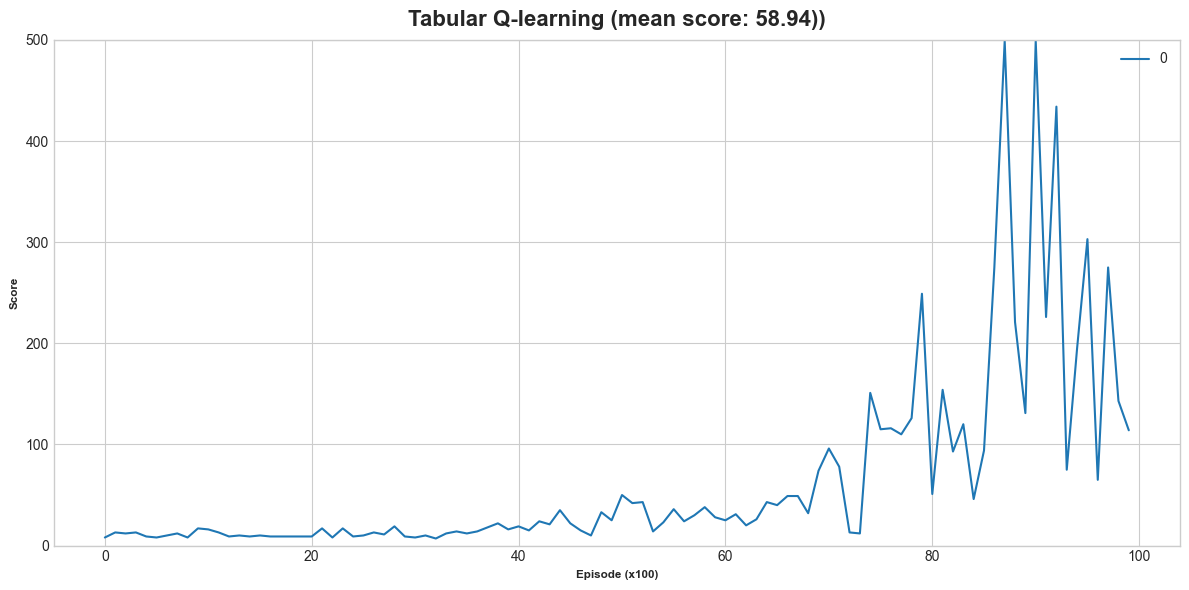

In [107]:
plot_data = pd.DataFrame(episode_scores.values())
sns.lineplot(plot_data.values[0::100]) # plot every 100th value so it's not too crowded
plt.title(f'Tabular Q-learning (mean score: {mean_score:.2f}))')
plt.xlabel('Episode (x100)')
plt.ylabel('Score')
plt.ylim(0,500)  # truncation happens at 500 steps
plt.show()

In [ ]:
# TODO wrap this up in a class
class RLAgent:
    def __init__(self, environment, strategy=None):
        self.env = environment
        self.strategy = strategy
        self.total_reward = 0

    def set_strategy(self, strategy):
        """Set the learning strategy (e.g., Q-learning, SARSA, etc.)."""
        self.strategy = strategy

    def learn(self, episodes):
        """Learn using the current strategy."""
        if self.strategy is None:
            raise ValueError("No strategy set!")
        
        for _ in range(episodes):
            self._run_episode()

    def _run_episode(self):
        state = self.env.reset()
        done = False
        
        while not done:
            action = self.strategy.select_action(state)
            next_state, reward, done, _ = self.env.step(action)
            self.strategy.update(state, action, reward, next_state, done)
            state = next_state
            self.total_reward += reward

    def evaluate(self):
        """Evaluate the current policy (possibly without exploration)."""
        # This could involve running episodes without exploration 
        # and recording metrics like average reward, episode length, etc.
        pass

    # ... any other utility methods ...

# Example usage:
agent = RLAgent(gym.make('CartPole-v1'))
agent.set_strategy(QlearningStrategy(parameters...))
agent.learn(1000)
agent.evaluate()


In [ ]:
# TODO record the results

In [ ]:
q_table

In [ ]:
# reward is +1 for every step, so the scores are just the episode lengths
results = {ep:len(scores) for ep, scores in episode_scores.items()}
pd.DataFrame(results, index=['episode_length']).T.plot(kind='bar')
plt.title(f'Tabular Q-learning')
plt.show()

### 3. Policy Gradient using Neural Networks:

**Objective**: Transition from tabular methods to function approximators like neural networks.

**Task**:
- Use a neural network to estimate the policy.
- Implement the REINFORCE algorithm or a similar vanilla policy gradient method.
- Update the policy based on the received rewards.

**Expected Outcome**:
- The agent will learn to balance the pole for longer durations.
- Understanding of how neural networks can be used in RL.



### 4. Deep Q-learning:

**Objective**: Learn how to use deep neural networks in value-based methods.

**Task**:
- Use a neural network as a Q-function approximator.
- Implement the DQN algorithm with experience replay and target networks.

**Expected Outcome**:
- Improved stability compared to simple Q-learning due to the use of neural networks and experience replay.
- Understanding of challenges like overestimation bias in Q-learning and the need for techniques like target networks.



### 5. Advanced DQN Variants:

**Objective**: Dive deeper into challenges and improvements in value-based deep RL.

**Task**:
- Explore algorithms like Double DQN, Dueling DQN, and Prioritized Experience Replay.
- Integrate these techniques into your DQN implementation.

**Expected Outcome**:
- Improved performance and stability.
- Comprehensive understanding of challenges in deep Q-learning and the methodologies to mitigate them.



### 6. Actor-Critic Methods:

**Objective**: Combine the benefits of value-based and policy-based methods.

**Task**:
- Implement a basic Actor-Critic model.
- Extend it to methods like Deep Deterministic Policy Gradient (DDPG) or Proximal Policy Optimization (PPO), even though these might be overkill for CartPole.

**Expected Outcome**:
- A balanced understanding of how value and policy methods can be combined.
- Familiarity with advanced RL algorithms.


## Random action

In [ ]:
env = gym.make("LunarLander-v2", render_mode="human")

In [ ]:
# 
env.action_space

In [ ]:
episodes = 10
for episode in range(episodes+1):

    # reset the evironment for each episode
    observation = env.reset()
    score = 0
    done = False 
    
    while not done:

        # possible actions at each step: do nothing, fire the main engine, fire the left orientation engine, or fire the right orientation engine 
        action = env.action_space.sample()  
        observation, reward, terminated, truncated, info = env.step(action)
        score += reward
        env.render()
        print(f"Episode: {episode} Score: {score}", end="\r")

        if terminated or truncated:
            done = True

env.close()